# Classification

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params

set_pyplot_params()

In [3]:
from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

In [4]:
import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + 
                                   marker_cycle + 
                                   line_cycle)

Classification might be the most well-known application of Bayesian methods, made famous in the 1990s as the basis of the first generation of [spam filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering).

In this chapter, I'll demonstrate Bayesian classification using data collected and made available by Dr. Kristen Gorman at the Palmer Long-Term Ecological Research Station in Antarctica (see Gorman, Williams, and Fraser, ["Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus *Pygoscelis*)"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), March 2014).
We'll use this data to classify penguins by species.

The following cell downloads the raw data.

In [6]:
# Load the data files from 
# https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

download('https://github.com/allisonhorst/palmerpenguins/raw/main/inst/extdata/penguins_raw.csv')

Downloaded penguins_raw.csv


## Penguin Data

I'll use Pandas to load the data into a `DataFrame`.

In [7]:
import pandas as pd

df = pd.read_csv('penguins_raw.csv')
df.shape

(344, 17)

The dataset contains one row for each penguin and one column for each variable.

In [8]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


For convenience, I'll create a new column called `Species2` that contains a shorter version of the species names.

In [9]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

Three species of penguins are represented in the dataset:  Adélie, Chinstrap and Gentoo.

These species are shown in this illustration (by Allison Horst, available under the [CC-BY](https://creativecommons.org/licenses/by/2.0/) license):

<img width="400" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAWkZ0U4AA1CQf.jpeg" alt="Drawing of three penguin species">

The measurements we'll use are:

* Body Mass in grams (g).

* Flipper Length in millimeters (mm).

* Culmen Length in millimeters.  

* Culmen Depth in millimeters.

If you are not familiar with the word "culmen", it refers to the [top margin of the beak](https://en.wikipedia.org/wiki/Bird_measurement#Culmen).

The culmen is shown in the following illustration (also by Allison Horst):

<img width="300" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAXQn8U4AAoKUj.jpeg">

These measurements will be most useful for classification if there are substantial differences between species and small variation within species.  To see whether that is true, and to what degree, I'll plot cumulative distribution functions (CDFs) of each measurement for each species. 

The following function takes the `DataFrame` and a column name.
It returns a dictionary that maps from each species name to a `Cdf` of the values in the column named `colname`.

In [10]:
def make_cdf_map(df, colname, by='Species2'):
    """Make a CDF for each species."""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

The following function plots a `Cdf` of the values in the given column for each species: 


下面的函数绘制了每个物种给定列中值的 Cdf:

In [11]:
from empiricaldist import Cdf
from utils import decorate

def plot_cdfs(df, colname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')
    
    decorate(xlabel=colname,
             ylabel='CDF')

Here's what the distributions look like for culmen length.

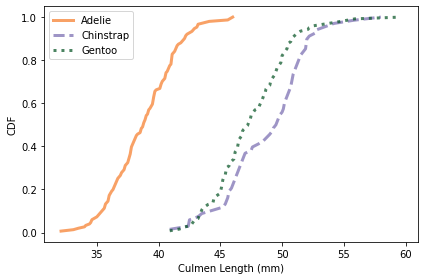

In [12]:
colname = 'Culmen Length (mm)'
plot_cdfs(df, colname)

It looks like we can use culmen length to identify  Adélie penguins, but the distributions for the other two species almost entirely overlap.

Here are the distributions for flipper length.

看起来我们可以使用 culmen 长度来识别阿德利企鹅，但其他两个物种的分布几乎完全重叠。

以下是鳍状肢长度的分布。

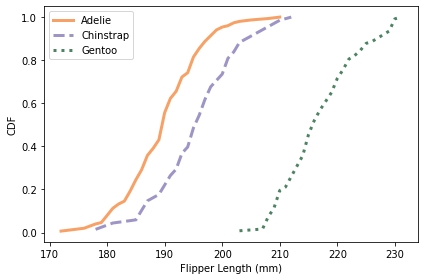

In [13]:
colname = 'Flipper Length (mm)'
plot_cdfs(df, colname)

Using flipper length, we can distinguish Gentoo penguins from the other two species.  So with just these two features, it seems like we should be able to classify penguins with some accuracy.

All of these CDFs show the sigmoid shape characteristic of the normal distribution;  I will take advantage of that observation in the next section.

Here are the distributions for culmen depth.

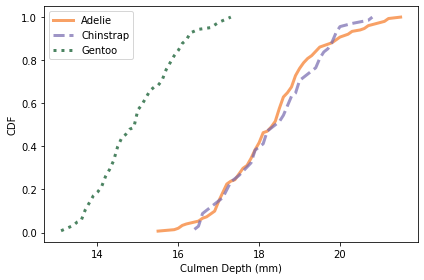

In [14]:
colname = 'Culmen Depth (mm)'
plot_cdfs(df, colname)

And here are the distributions of body mass.

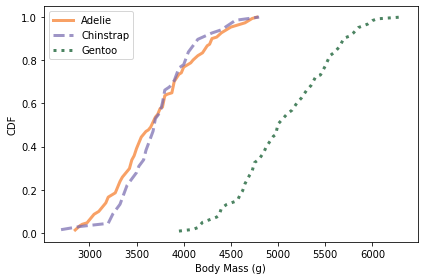

In [15]:
colname = 'Body Mass (g)'
plot_cdfs(df, colname)

Culmen depth and body mass distinguish Gentoo penguins from the other two species, but these features might not add a lot of additional information, beyond what we get from flipper length and culmen length.

库门深度和体重将巴布亚企鹅与其他两个物种区分开来，但这些特征可能不会增加很多额外的信息，除了我们从鳍状肢长度和库门长度得到的信息。

## Normal Models

Let's use these features to classify penguins. We'll proceed in the usual Bayesian way:

1. Define a prior distribution with the three possible species and a prior probability for each,

2. Compute the likelihood of the data for each hypothetical species, and then

3. Compute the posterior probability of each hypothesis.

To compute the likelihood of the data under each hypothesis, I'll use the data to estimate the parameters of a normal distribution for each species.

The following function takes a `DataFrame` and a column name; it returns a dictionary that maps from each species name to a `norm` object.

`norm` is defined in SciPy; it represents a normal distribution with a given mean and standard deviation.

## 普通模型

让我们使用这些特征对企鹅进行分类。 我们将按照通常的贝叶斯方式进行：

1. 定义三个可能物种的先验分布和每个物种的先验概率，

2. 计算每个假设物种的数据的可能性，然后

3. 计算每个假设的后验概率。

为了计算每个假设下数据的可能性，我将使用这些数据来估计每个物种的正态分布参数。

以下函数采用“DataFrame”和列名； 它返回一个字典，将每个物种名称映射到一个“规范”对象。

`norm` 在 SciPy 中定义； 它表示具有给定均值和标准差的正态分布。

In [16]:
from scipy.stats import norm

def make_norm_map(df, colname, by='Species2'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

For example, here's the dictionary of `norm` objects for flipper length:

例如，这里是关于鳍状肢长度的 `norm` 对象的字典：

In [18]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map.keys()

dict_keys(['Adelie', 'Chinstrap', 'Gentoo'])

Now suppose we measure a penguin and find that its flipper is 193 cm.  What is the probability of that measurement under each hypothesis?

The `norm` object provides `pdf`, which computes the probability density function (PDF) of the normal distribution.  We can use it to compute the likelihood of the observed data in a given distribution.

现在假设我们测量一只企鹅，发现它的鳍状物是 193 厘米。 在每个假设下该测量的概率是多少？

`norm` 对象提供 `pdf`，它计算正态分布的概率密度函数 (PDF)。 我们可以使用它来计算给定分布中观察到的数据的可能性。

In [19]:
data = 193
flipper_map['Adelie'].pdf(data)

0.054732511875530694

The result is a probability density, so we can't interpret it as a probability.  But it is proportional to the likelihood of the data, so we can use it to update the prior.

Here's how we compute the likelihood of the data in each distribution.

结果是概率密度，因此我们不能将其解释为概率。 但它与数据的可能性成正比，因此我们可以使用它来更新先验。

以下是我们如何计算每个分布中数据的可能性。

In [21]:
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.05172135615888162, 5.866045366199064e-05]

Now we're ready to do the update.

现在我们准备好进行更新了。

## The Update

As usual I'll use a `Pmf` to represent the prior distribution.  For simplicity, let's assume that the three species are equally likely.

像往常一样，我将使用 Pmf 来表示先前的分布。为了简单起见，我们假设这三个物种的可能性相等。

In [22]:
from empiricaldist import Pmf

prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


Now we can do the update in the usual way.

In [23]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


A penguin with a 193 mm flipper is unlikely to be a Gentoo, but might be either an Adélie or Chinstrap (assuming that the three species were equally likely before the measurement). 

The following function encapsulates the steps we just ran.
It takes a `Pmf` representing the prior distribution, the observed data, and a map from each hypothesis to the distribution of the feature.

具有 193 毫米鳍状肢的企鹅不太可能是 Gentoo，但可能是 Adélie 或 Chinstrap（假设这三个物种在测量前的可能性相同）。

下面的函数封装了我们刚刚运行的步骤。
它需要一个表示先验分布的“Pmf”、观察到的数据以及从每个假设到特征分布的映射。

In [24]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs ##数值
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos] ## 从一个·数字计算似然
    posterior = prior * likelihood
    posterior.normalize()  ## 归一化
    return posterior ### 返回后验是和先验相等大小

The return value is the posterior distribution.

Here's the previous example again, using `update_penguin`:

返回值是后验分布。

这是前面的例子，使用 `update_penguin`：

In [25]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


In [62]:
df

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Species2,Classification
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.,Adelie,Adelie
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN,Adelie,Adelie
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN,Adelie,Adelie
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.,Adelie,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN,Adelie,Adelie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,PAL0910,64,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N98A2,Yes,2009-11-19,55.8,19.8,207.0,4000.0,MALE,9.70465,-24.53494,NaN,Chinstrap,Chinstrap
340,PAL0910,65,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N99A1,No,2009-11-21,43.5,18.1,202.0,3400.0,FEMALE,9.37608,-24.40753,Nest never observed with full clutch.,Chinstrap,Adelie
341,PAL0910,66,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N99A2,No,2009-11-21,49.6,18.2,193.0,3775.0,MALE,9.46180,-24.70615,Nest never observed with full clutch.,Chinstrap,Chinstrap
342,PAL0910,67,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N100A1,Yes,2009-11-21,50.8,19.0,210.0,4100.0,MALE,9.98044,-24.68741,NaN,Chinstrap,Chinstrap


As we saw in the CDFs, flipper length does not distinguish strongly between Adélie and Chinstrap penguins.

But culmen length *can* make this distinction, so let's use it to do a second round of classification.
First we estimate distributions of culmen length for each species like this:

正如我们在 CDF 中看到的，鳍状肢长度在阿德利企鹅和帽带企鹅之间并没有明显区别。

但是 culmen length *可以*做出这种区分，所以让我们用它来做第二轮分类。
首先，我们估计每个物种的尖顶长度分布，如下所示：

In [26]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

In [66]:
make_norm_map  # 计算那一列的均值和方差，
### 然后构造一个norm对象，也就是根据均值和方差构建正太分布


<function __main__.make_norm_map(df, colname, by='Species2')>

In [63]:
culmen_map 

{'Adelie': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f467dcf58e0>,
 'Chinstrap': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f467dc60760>,
 'Gentoo': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f467dd2db80>}

Now suppose we see a penguin with culmen length 48 mm.
We can use this data to update the prior.

现在假设我们看到一只企鹅的顶梁长度为 48 毫米。
我们可以使用这些数据来更新先验。

In [27]:
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,probs
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


In [64]:
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


A penguin with culmen length 48 mm is about equally likely to be a Chinstrap or Gentoo.

Using one feature at a time, we can often rule out one species or another, but we generally can't identify species with confidence.
We can do better using multiple features.

顶盖长度为 48 毫米的企鹅与帽带或巴布亚企鹅的可能性大致相同。

一次使用一个特征，我们通常可以排除一个或另一个物种，但我们通常不能自信地识别物种。
我们可以使用多种功能做得更好。

## Naive Bayesian Classification

To make it easier to do multiple updates, I'll use the following function, which takes a prior `Pmf`, a sequence of measurements and a corresponding sequence of dictionaries containing estimated distributions.

## 朴素贝叶斯分类

为了更容易进行多次更新，我将使用以下函数，该函数采用先验“Pmf”、一系列测量值和包含估计分布的相应字典序列。

In [28]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution  ##映射到分布上的数据
    
    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior
 ### 循环生成计算后验，更新后验

It performs a series of updates, using one variable at a time, and returns the posterior `Pmf`.

To test it, I'll use the same features we looked at in the previous section: culmen length and flipper length.

它执行一系列更新，一次使用一个变量，并返回后验“Pmf”。

为了测试它，我将使用我们在上一节中看到的相同特征：尖顶长度和鳍状肢长度。

In [29]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

Now suppose we find a penguin with flipper length 193 mm and culmen length 48.
Here's the update:

现在假设我们找到了一只鳍长 193 毫米、脚蹼长 48 的企鹅。
这是更新：

In [30]:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


It is almost certain to be a Chinstrap.

In [31]:
posterior.max_prob()

'Chinstrap'

We can loop through the dataset and classify each penguin with these two features.

我们可以遍历数据集并使用这两个特征对每只企鹅进行分类。

In [65]:
import numpy as np

df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

This loop adds a column called `Classification` to the `DataFrame`; it contains the species with the maximum posterior probability for each penguin.

So let's see how many we got right.

这个循环在 `DataFrame` 中添加一个名为 `Classification` 的列； 它包含每只企鹅具有最大后验概率的物种。

所以让我们看看我们做对了多少。

In [33]:
len(df)

344

In [34]:
valid = df['Classification'].notna()
valid.sum()

342

In [35]:
same = df['Species2'] == df['Classification']
same.sum()

324

There are 344 penguins in the dataset, but two of them are missing measurements, so we have 342 valid cases.
Of those, 324 are classified correctly, which is almost 95%.

数据集中有 344 只企鹅，但其中有两只缺少测量值，因此我们有 342 个有效案例。
其中，324 个被正确分类，几乎是 95%。

In [36]:
same.sum() / valid.sum()

0.9473684210526315

The following function encapsulates these steps.

以下函数封装了这些步骤。

In [37]:
def accuracy(df):
    """Compute the accuracy of classification."""
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

The classifier we used in this section is called "naive" because it ignores correlations between the features.  To see why that matters, I'll make a less naive classifier: one that takes into account the joint distribution of the features.

我们在本节中使用的分类器被称为“naive”，因为它忽略了特征之间的相关性。 为了了解为什么这很重要，我将制作一个不那么简单的分类器：一个考虑到特征的联合分布的分类器。

## Joint Distributions

I'll start by making a scatter plot of the data.

## 联合分布

我将从制作数据的散点图开始。


In [38]:
import matplotlib.pyplot as plt

def scatterplot(df, var1, var2):
    """Make a scatter plot."""
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var1], group[var2],
                 label=species, lw=0, alpha=0.3)
    
    decorate(xlabel=var1, ylabel=var2)

Here's a scatter plot of culmen length and flipper length for the three species.

这是三个物种的茎秆长度和鳍状肢长度的散点图。

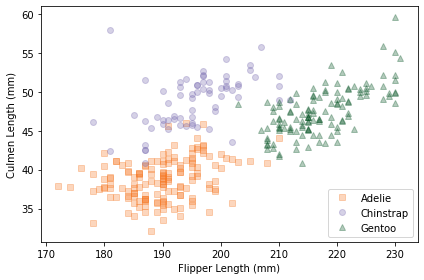

In [39]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

Within each species, the joint distribution of these measurements forms an oval shape, at least roughly.  The orientation of the ovals is along a diagonal, which indicates that there is a correlation between culmen length and flipper length.

If we ignore these correlations, we are assuming that the features are independent.  To see what that looks like, I'll make a joint distribution for each species assuming independence.

The following function makes a discrete `Pmf` that approximates a normal distribution.

在每个物种中，这些测量值的联合分布至少大致呈椭圆形。 椭圆的方向是沿对角线的，这表明顶杆长度和鳍板长度之间存在相关性。

如果我们忽略这些相关性，我们假设这些特征是独立的。 为了看看这是什么样子，我将为每个物种进行联合分布，假设它们是独立的。

以下函数生成近似正态分布的离散“Pmf”。

In [40]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution."""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std  ## 均值-3标准差
    high = mean + sigmas * std ## 均值+3标准差
    qs = np.linspace(low, high, n) ## 生成一个数组，从low到high，n个数
    ps = dist.pdf(qs) ## 计算概率密度函数
    pmf = Pmf(ps, qs) ## 构造一个pmf对象,qs是数值，ps是概率,概率质量函数，离散
    pmf.normalize()
    return pmf

We can use it, along with `make_joint`, to make a joint distribution of culmen length and flipper length for each species.

我们可以使用它和 `make_joint` 来为每个物种制作尖顶长度和鳍状肢长度的联合分布。


In [69]:
for species in hypos:
    print(species,flipper_map[species])

Adelie <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f467dd62eb0>
Chinstrap <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f467dd62ee0>
Gentoo <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f467dce9c40>


In [67]:
flipper_map[species]

In [41]:
from utils import make_joint

joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

The following figure compares a scatter plot of the data to the contours of the joint distributions, assuming independence.

下图将数据的散点图与联合分布的轮廓进行了比较，假设独立。

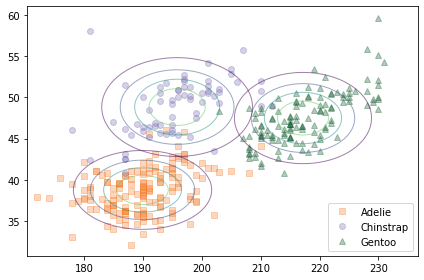

In [42]:
from utils import plot_contour

scatterplot(df, var1, var2)
for species in hypos:
    plot_contour(joint_map[species], alpha=0.5)

The contours of a joint normal distribution form ellipses.
In this example, because the features are uncorrelated, the ellipses are aligned with the axes.
But they are not well aligned with the data.

We can make a better model of the data, and use it to compute better likelihoods, with a multivariate normal distribution.

联合正态分布的轮廓形成椭圆。
在此示例中，由于特征不相关，因此椭圆与轴对齐。
但它们与数据并没有很好地对齐。

我们可以制作更好的数据模型，并使用它来计算更好的可能性，并具有多元正态分布。

## Multivariate Normal Distribution

As we have seen, a univariate normal distribution is characterized by its mean and standard deviation.

A multivariate normal distribution is characterized by the means of the features and the **covariance matrix**, which contains **variances**, which quantify the spread of the features, and the **covariances**, which quantify the relationships among them.

We can use the data to estimate the means and covariance matrix for the population of penguins.
First I'll select the columns we want.

## 多元正态分布

正如我们所见，单变量正态分布的特征在于其均值和标准差。

多元正态分布通过特征和**协方差矩阵**来表征，其中包含量化特征传播的**方差**和量化特征 他们之间关系的**协方差**。

我们可以使用这些数据来估计企鹅种群的均值和协方差矩阵。
首先，我将选择我们想要的列。

In [43]:
features = df[[var1, var2]]

In [73]:
features 

,Flipper Length (mm),Culmen Length (mm)
0,181.0,39.1
1,186.0,39.5
2,195.0,40.3
3,NaN,NaN
4,193.0,36.7
...,...,...
339,207.0,55.8
340,202.0,43.5
341,193.0,49.6
342,210.0,50.8


And compute the means.

In [44]:
mean = features.mean()
mean

Flipper Length (mm)    200.915205
Culmen Length (mm)      43.921930
dtype: float64

We can also compute the covariance matrix:

In [45]:
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


The result is a `DataFrame` with one row and one column for each feature.  The elements on the diagonal are the variances; the elements off the diagonal are covariances.

By themselves, variances and covariances are hard to interpret.  We can use them to compute standard deviations and correlation coefficients, which are easier to interpret, but the details of that calculation are not important right now.

Instead, we'll pass the covariance matrix to `multivariate_normal`, which is a SciPy function that creates an object that represents a multivariate normal distribution.

As arguments it takes a sequence of means and a covariance matrix: 

结果是一个“DataFrame”，每个特征都有一行和一列。 对角线上的元素是方差； 对角线以外的元素是协方差。

就其本身而言，方差和协方差很难解释。 我们可以使用它们来计算标准差和相关系数，这更容易解释，但计算的细节现在并不重要。

相反，我们将协方差矩阵传递给“multivariate_normal”，这是一个 SciPy 函数，它创建一个表示多元正态分布的对象。

作为参数，它需要一系列均值和协方差矩阵：

In [72]:
from scipy.stats import multivariate_normal

multinorm = multivariate_normal(mean, cov) ## 表示多元正态分布的对象。

In [74]:
multinorm 

The following function makes a `multivariate_normal` object for each species.

以下函数为每个物种创建一个“multivariate_normal”对象。

In [47]:
def make_multinorm_map(df, colnames):
    """Make a map from each species to a multivariate normal."""
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

Here's how we make this map for the first two features, flipper length and culmen length.

下面是我们如何为前两个特征制作这张地图，鳍状肢长度和顶梁长度。

In [48]:
multinorm_map = make_multinorm_map(df, [var1, var2])

In [75]:
multinorm_map

{'Adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f46802a5cd0>,
 'Chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f467db9a520>,
 'Gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f467db77b50>}

## Visualizing a Multivariate Normal Distribution

This section uses some NumPy magic to generate contour plots for multivariate normal distributions.  If that's interesting for you, great!  Otherwise, feel free to skip to the results.  In the next section we'll do the actual classification, which turns out to be easier than the visualization.

I'll start by making a contour map for the distribution of features among Adélie penguins.  
Here are the univariate distributions for the two features we'll use and the multivariate distribution we just computed.

## 可视化多元正态分布

本节使用一些 NumPy 魔法来生成多元正态分布的等高线图。 如果这对您来说很有趣，那就太好了！ 否则，请随意跳到结果。 在下一节中，我们将进行实际的分类，结果证明这比可视化更容易。

我将首先制作阿德利企鹅之间特征分布的等高线图。
这是我们将使用的两个特征的单变量分布和我们刚刚计算的多变量分布。

In [49]:
norm1 = flipper_map['Adelie']
norm2 = culmen_map['Adelie']
multinorm = multinorm_map['Adelie']

In [76]:
multinorm

I'll make a discrete `Pmf` approximation for each of the univariate distributions.

In [50]:
pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2)

And use them to make a mesh grid that contains all pairs of values.

并使用它们制作一个包含所有值对的网格。

In [51]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

In [77]:
X

array([[170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464],
       [170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464],
       [170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464],
       ...,
       [170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464],
       [170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464],
       [170.33527013, 170.72763758, 171.12000502, ..., 208.78727975,
        209.17964719, 209.57201464]])

In [78]:
Y

array([[30.80117618, 30.80117618, 30.80117618, ..., 30.80117618,
        30.80117618, 30.80117618],
       [30.96098047, 30.96098047, 30.96098047, ..., 30.96098047,
        30.96098047, 30.96098047],
       [31.12078477, 31.12078477, 31.12078477, ..., 31.12078477,
        31.12078477, 31.12078477],
       ...,
       [46.46199669, 46.46199669, 46.46199669, ..., 46.46199669,
        46.46199669, 46.46199669],
       [46.62180098, 46.62180098, 46.62180098, ..., 46.62180098,
        46.62180098, 46.62180098],
       [46.78160527, 46.78160527, 46.78160527, ..., 46.78160527,
        46.78160527, 46.78160527]])

The mesh is represented by two arrays: the first contains the quantities from `pmf1` along the `x` axis; the second contains the quantities from `pmf2` along the `y` axis.

In order to evaluate the multivariate distribution for each pair of values, we have to "stack" the arrays.

网格由两个数组表示：第一个包含来自 pmf1 沿 x 轴的数量； 第二个包含来自“pmf2”沿“y”轴的数量。

为了评估每对值的多元分布，我们必须“堆叠”数组。



stack（）：沿着新的轴加入一系列数组。

vstack（）：堆栈数组垂直顺序（行）

hstack（）：堆栈数组水平顺序（列）。

dstack（）：堆栈数组按顺序深入（沿第三维）。

concatenate（）：连接沿现有轴的数组序列。

vsplit（）：将数组分解成垂直的多个子数组的列表。

In [52]:
pos = np.dstack((X, Y))
pos.shape ##也就是当作第三维合并

(101, 101, 2)

The result is a 3-D array that you can think of as a 2-D array of pairs.  When we pass this array to `multinorm.pdf`, it evaluates the probability density function of the distribution for each pair of values.

结果是一个 3-D 数组，您可以将其视为 2-D 数组对。 当我们将此数组传递给“multinorm.pdf”时，它会评估每对值的分布的概率密度函数。

In [79]:
densities = multinorm.pdf(pos)
densities.shape

(101, 101)

In [80]:
densities

array([[1.11814702e-04, 1.15059501e-04, 1.18236683e-04, ...,
        2.77697826e-06, 2.49920270e-06, 2.24613917e-06],
       [1.17480655e-04, 1.21003709e-04, 1.24462116e-04, ...,
        3.19961059e-06, 2.88227142e-06, 2.59285841e-06],
       [1.23248139e-04, 1.27063683e-04, 1.30818355e-04, ...,
        3.68102132e-06, 3.31905790e-06, 2.98859801e-06],
       ...,
       [1.11305129e-05, 1.25601825e-05, 1.41541208e-05, ...,
        2.32913173e-03, 2.29868918e-03, 2.26554466e-03],
       [1.00912657e-05, 1.13981708e-05, 1.28567399e-05, ...,
        2.31569690e-03, 2.28758194e-03, 2.25672055e-03],
       [9.13529690e-06, 1.03281119e-05, 1.16607203e-05, ...,
        2.29887807e-03, 2.27310570e-03, 2.24455112e-03]])

The result is an array of probability densities.  If we put them in a `DataFrame` and normalize them, the result is a discrete approximation of the joint distribution of the two features.

结果是一系列概率密度。 如果我们将它们放入“DataFrame”并对其进行归一化，则结果是两个特征的联合分布的离散近似。

In [54]:
from utils import normalize

joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
normalize(joint)

15.871343639913828

Here's what the result looks like.

结果如下。

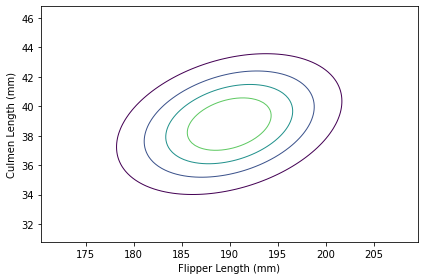

In [55]:
plot_contour(joint)
decorate(xlabel=var1,
         ylabel=var2)

The contours of a multivariate normal distribution are still ellipses, but now that we have taken into account the correlation between the features, the ellipses are no longer aligned with the axes.

The following function encapsulate the steps we just did.

多元正态分布的轮廓仍然是椭圆，但现在我们已经考虑了特征之间的相关性，椭圆不再与轴对齐。

下面的函数封装了我们刚刚做的步骤。

In [71]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

The following figure shows a scatter plot of the data along with the contours of the multivariate normal distribution for each species.

下图显示了数据的散点图以及每个物种的多元正态分布的轮廓。

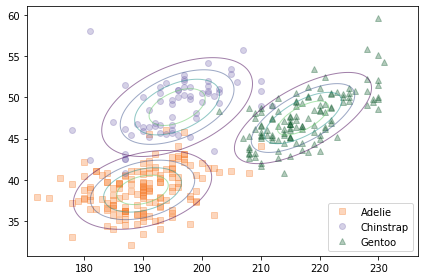

In [57]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.5)

Because the multivariate normal distribution takes into account the correlations between features, it is a better model for the data.  And there is less overlap in the contours of the three distributions, which suggests that they should yield better classifications.

因为多元正态分布考虑了特征之间的相关性，所以它是更好的数据模型。 并且三个分布的轮廓重叠较少，这表明它们应该产生更好的分类。

## A Less Naive Classifier

In a previous section we used `update_penguin` to update a prior `Pmf` based on observed data and a collection of `norm` objects that model the distribution of observations under each hypothesis.  Here it is again:

## 一个不那么简单的分类器

在上一节中，我们使用“update_penguin”根据观察到的数据和一组“norm”对象来更新先前的“Pmf”，这些对象对每个假设下的观察分布进行建模。 这里又是：

In [58]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

Last time we used this function, the values in `norm_map` were `norm` objects, but it also works if they are `multivariate_normal` objects.

We can use it to classify a penguin with flipper length 193 and culmen length 48:

上次我们使用这个函数时，`norm_map` 中的值是 `norm` 对象，但如果它们是 `multivariate_normal` 对象，它也可以工作。

我们可以用它来分类一只鳍状肢长度为 193 和鳍状肢长度为 48 的企鹅：

In [59]:
data = 193, 48
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


A penguin with those measurements is almost certainly a Chinstrap.

Now let's see if this classifier does any better than the naive Bayesian classifier.
I'll apply it to each penguin in the dataset:

具有这些尺寸的企鹅几乎可以肯定是帽带。

现在让我们看看这个分类器是否比朴素贝叶斯分类器做得更好。
我将把它应用到数据集中的每只企鹅：

In [60]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

And compute the accuracy:

In [61]:
accuracy(df)

0.9532163742690059

It turns out to be only a little better: the accuracy is 95.3%, compared to 94.7% for the naive Bayesian classifier.

## Summary

In this chapter, we implemented a naive Bayesian classifier, which is "naive" in the sense that it assumes that the features it uses for classification are independent.

To see how bad that assumption is, we also implemented a classifier that uses a multivariate normal distribution to model the joint distribution of the features, which includes their dependencies.

In this example, the non-naive classifier is only marginally better.
In one way, that's disappointing.  After all that work, it would have been nice to see a bigger improvement.
But in another way, it's good news.  In general, a naive Bayesian classifier is easier to implement and requires less computation.  If it works nearly as well as a more complex algorithm, it might be a good choice for practical purposes.

Speaking of practical purposes, you might have noticed that this example isn't very useful.  If we want to identify the species of a penguin, there are easier ways than measuring its flippers and beak.

But there *are* scientific uses for this type of classification.  One of them is the subject of the research paper we started with: [sexual dimorphism](https://en.wikipedia.org/wiki/Sexual_dimorphism), that is, differences in shape between male and female animals.

In some species, like angler fish, males and females look very different.  In other species, like mockingbirds, they are difficult to tell apart.
And dimorphism is worth studying because it provides insight into social behavior, sexual selection, and evolution. 

One way to quantify the degree of sexual dimorphism in a species is to use a classification algorithm like the one in this chapter.  If you can find a set of features that makes it possible to classify individuals by sex with high accuracy, that's evidence of high dimorphism.

As an exercise, you can use the dataset from this chapter to classify penguins by sex and see which of the three species is the most dimorphic.

## 概括

在本章中，我们实现了一个朴素贝叶斯分类器，它是“朴素的”，因为它假设它用于分类的特征是独立的。

为了看看这个假设有多糟糕，我们还实现了一个分类器，它使用多元正态分布来模拟特征的联合分布，其中包括它们的依赖关系。

在这个例子中，非朴素分类器只是稍微好一点。
一方面，这令人失望。在所有这些工作之后，很高兴看到更大的改进。
但另一方面，这是个好消息。一般来说，朴素贝叶斯分类器更容易​​实现并且需要更少的计算。如果它的工作原理几乎与更复杂的算法一样好，那么它可能是实际用途的不错选择。

说到实际目的，您可能已经注意到这个示例不是很有用。如果我们想识别企鹅的种类，有比测量它的鳍状肢和喙更简单的方法。

但是这种分类有*有*科学用途。其中之一是我们开始研究论文的主题：[性二态]（https://en.wikipedia.org/wiki/Sexual_dimorphism），即雄性和雌性动物的形状差异。

在某些物种中，如琵琶鱼，雄性和雌性看起来非常不同。在其他物种中，如知更鸟，它们很难区分。
二态性值得研究，因为它提供了对社会行为、性选择和进化的洞察力。

量化一个物种中性二态性程度的一种方法是使用本章中的分类算法。如果你能找到一组特征，可以高精度地按性别对个体进行分类，那就是高度二态性的证据。

作为练习，您可以使用本章中的数据集按性别对企鹅进行分类，看看这三个物种中哪一个是最二态的。

## Exercises

**Exercise:**  In my example I used culmen length and flipper length because they seemed to provide the most power to distinguish the three species.  But maybe we can do better by using more features.

Make a naive Bayesian classifier that uses all four measurements in the dataset: culmen length and depth, flipper length, and body mass.
Is it more accurate than the model with two features?

**练习：** 在我的示例中，我使用了 culmen 长度和鳍状肢长度，因为它们似乎提供了区分这三个物种的最大能力。 但也许我们可以通过使用更多功能做得更好。

制作一个朴素贝叶斯分类器，该分类器使用数据集中的所有四个测量值：尖顶长度和深度、鳍状肢长度和体重。
它比具有两个特征的模型更准确吗？

In [60]:
# Solution goes here

In [61]:
# Solution goes here

In [62]:
# Solution goes here

**Exercise:**  One of the reasons the penguin dataset was collected was to quantify sexual dimorphism in different penguin species, that is, physical differences between male and female penguins.  One way to quantify dimorphism is to use measurements to classify penguins by sex.  If a species is more dimorphic, we expect to be able to classify them more accurately.

As an exercise, pick a species and use a Bayesian classifier (naive or not) to classify the penguins by sex.  Which features are most useful?  What accuracy can you achieve?

**练习：** 收集企鹅数据集的原因之一是量化不同企鹅物种的性别二态性，即雄性和雌性企鹅之间的身体差异。 量化二态性的一种方法是使用测量值按性别对企鹅进行分类。 如果一个物种更具二态性，我们希望能够更准确地对它们进行分类。

作为练习，选择一个物种并使用贝叶斯分类器（无论是否简单）按性别对企鹅进行分类。 哪些功能最有用？ 你能达到什么精度？

Note: One Gentoo penguin has an invalid value for `Sex`.  I used the following code to select one species and filter out invalid data.

注意：一只 Gentoo 企鹅的 `Sex` 值无效。 我使用以下代码选择了一个物种并过滤掉了无效数据。

In [81]:
gentoo = (df['Species2'] == 'Gentoo')
subset = df[gentoo].copy()

In [82]:
subset['Sex'].value_counts()

MALE      61
FEMALE    58
Name: Sex, dtype: int64

In [83]:
valid = df['Sex'] != '.'
valid.sum()

344

In [66]:
subset = df[valid & gentoo].copy()

OK, you can finish it off from here.

好的，你可以从这里完成它。

In [67]:
# Solution goes here

In [68]:
# Solution goes here

In [69]:
# Solution goes here

In [70]:
# Solution goes here

In [71]:
# Solution goes here

In [72]:
# Solution goes here

In [73]:
# Solution goes here

In [74]:
# Solution goes here

In [75]:
# Solution goes here

In [76]:
# Solution goes here

In [77]:
# Solution goes here

In [78]:
# Solution goes here

In [79]:
# Solution goes here

In [80]:
# Solution goes here